# Monowai CC tests

In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
import xcorr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib notebook

### open a file

In [120]:
root = '../data/results'
time = pd.to_datetime('2015-01-15')

hydro = {
    'network'  : 'IM',
    'station'  : 'H10N3',
    'location' : '',
    'channel'  : 'EDH',
}
seism = {
    'network'  : 'IU',
    'station'  : 'RAR',
    'location' : '10',
    'channel'  : 'BHZ',
}

vel = dict( min=1.46, max=1.50 )
filter_params = dict(frequency=3., btype='highpass', order=2, inplace=True)
taper_params = dict(max_length=2/3., inplace=True)

bhz = xcorr.read(xcorr.util.ncfile((hydro, seism), time, root), fast=True)
bhr = xcorr.read(xcorr.util.ncfile((hydro, {**seism,'channel':'BHR'}), time, root), fast=True)

assert bhz, 'No data found!'

if bhz:
    xcorr.signal.filter(bhz.cc, **filter_params)
    xcorr.signal.taper(bhz.cc, **taper_params)
    xcorr.bias_correct(bhz,unbiased_var='cc_w')
if bhr:
    xcorr.signal.filter(bhr.cc, **filter_params)
    xcorr.signal.taper(bhr.cc, **taper_params)
    xcorr.bias_correct(bhr,unbiased_var='cc_w')

### CCF noise window

<IPython.core.display.Javascript object>


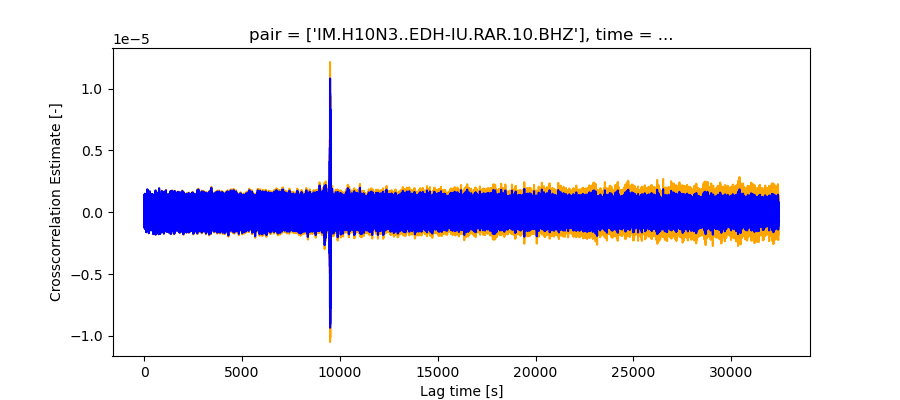

In [121]:
plt.figure(figsize=[9,4])
bhz.cc_w.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='orange')
bhz.cc.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='blue')

In [102]:
noise_win = xcorr.signal.mask(
    x=bhz.lag,
    lower=.2,
    upper=.25,
    scalar=bhz.time.window_length
)

signal_win = xcorr.signal.mask(
    x=bhz.lag,
    lower=1/vel['max'],
    upper=1/vel['min'],
    scalar=bhz.distance.values[0]
)

valid_win = xcorr.signal.mask(
    x=bhz.lag,
    upper=.25,
    scalar=bhz.time.window_length
)

i = 1

<IPython.core.display.Javascript object>


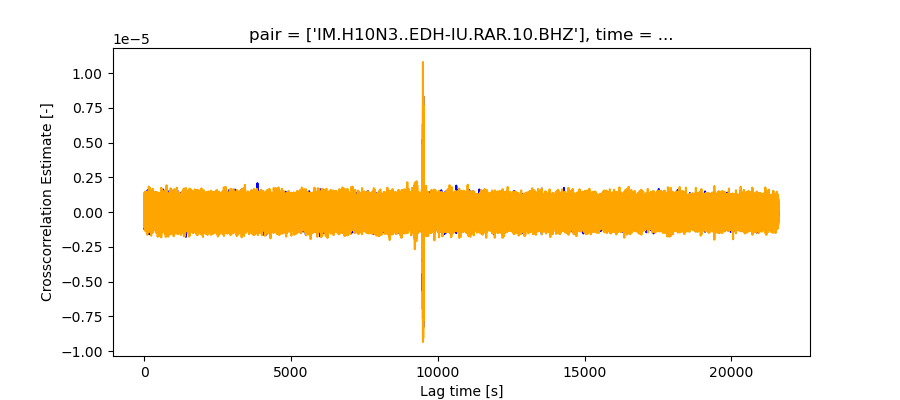

In [103]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


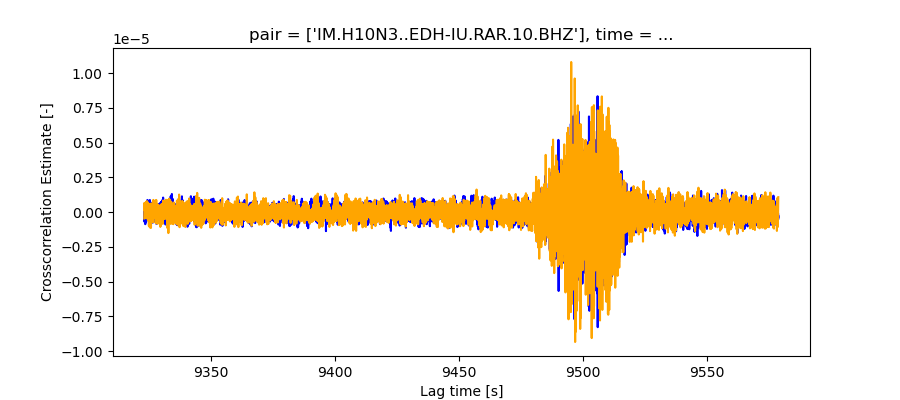

In [104]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


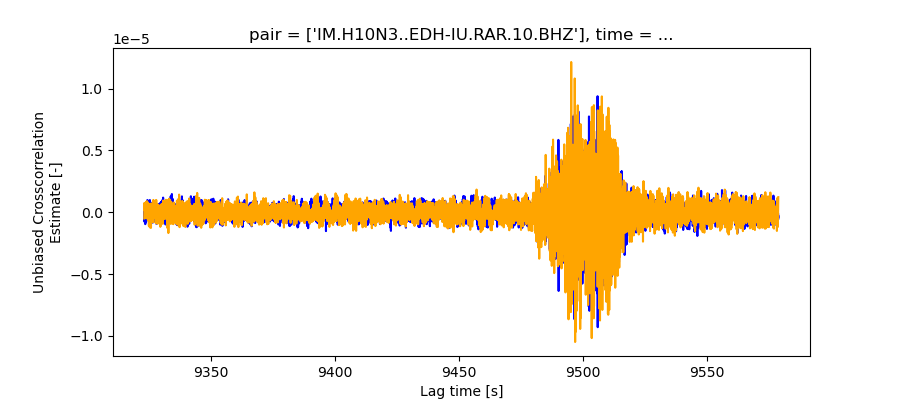

In [105]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

<IPython.core.display.Javascript object>


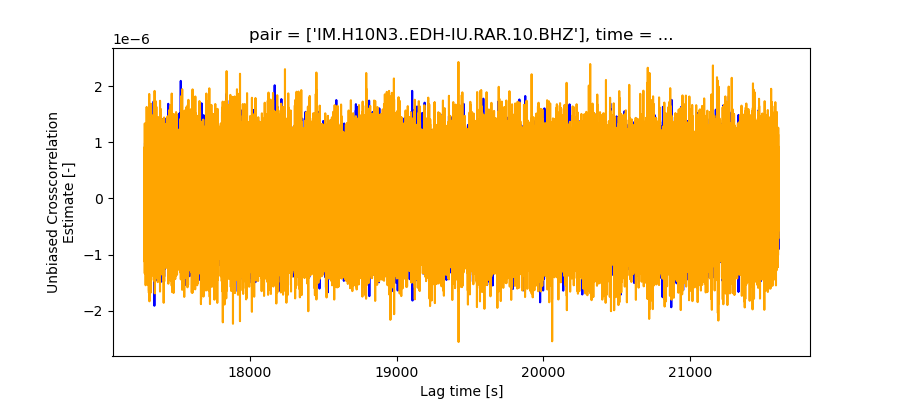

In [106]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='orange')

In [107]:
bhz['snr'] = xcorr.signal.snr(x=bhz.cc, signal=signal_win, noise=noise_win)
bhr['snr'] = xcorr.signal.snr(x=bhr.cc, signal=signal_win, noise=noise_win)

In [108]:
bhz.snr

<xarray.DataArray 'snr' (pair: 1, time: 8)>
array([[ 28.30486072,  25.67553955,  25.46121673,  26.55294113,
         20.30073761,  15.12653313,  12.26560454,  18.58669958]])
Coordinates:
  * pair     (pair) object 'IM.H10N3..EDH-IU.RAR.10.BHZ'
  * time     (time) datetime64[ns] 2015-01-15 ... 2015-01-15T21:00:00
Attributes:
    long_name:      signal-to-noise ratio
    standard_name:  signal_to_noise_ratio
    units:          -
    from_variable:  cc
    history:        xcorr-0.1.dev109+g941d3c8.d20200403: filter({"x":"cc","fr...

<IPython.core.display.Javascript object>


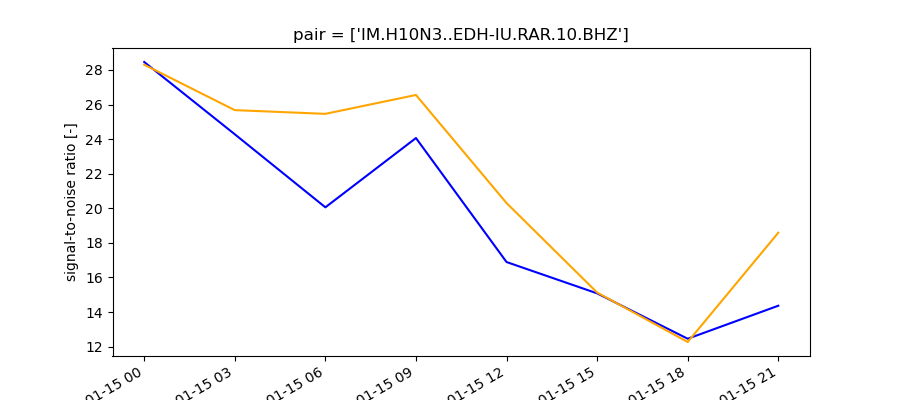

In [109]:
plt.figure(figsize=[9,4])
bhr.snr.plot.line(x='time',add_legend=False,color='blue')
bhz.snr.plot.line(x='time',add_legend=False,color='orange')

### xcorr full day (#8)

<IPython.core.display.Javascript object>


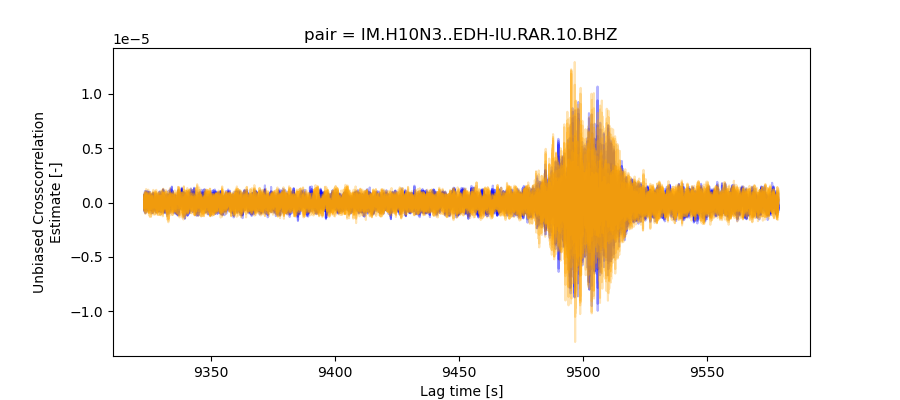

In [110]:
snr_min = 5

plt.figure(figsize=[9,4])
if bhr:
    snr_pass = bhr.snr.loc[{'pair':bhr.pair[0]}] >= snr_min
    if any(snr_pass):
        bhr.cc_w.loc[{
            'time':bhr.time[snr_pass],
            'lag':bhr.lag[signal_win],
            'pair':bhr.pair[0]
        }].plot.line(x='lag',add_legend=False,color='blue',alpha=0.3)
if bhz:
    snr_pass = bhz.snr.loc[{'pair':bhz.pair[0]}] >= snr_min
    if any(snr_pass):
        bhz.cc_w.loc[{
            'time':bhz.time[snr_pass],
            'lag':bhz.lag[signal_win],
            'pair':bhz.pair[0]
        }].plot.line(x='lag',add_legend=False,color='orange',alpha=0.3)

## Spectrogram

In [111]:
psd = xcorr.signal.psd(
    bhz.cc_w.loc[{'lag':bhz.lag[signal_win]}],
    duration = 2.,
    padding_factor = 4,
)

<IPython.core.display.Javascript object>


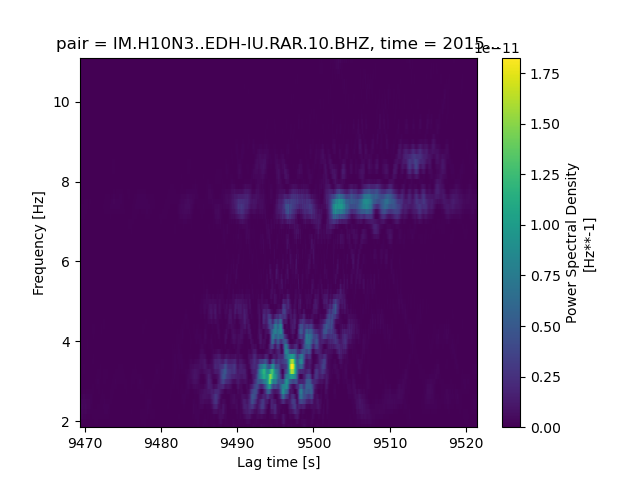

In [112]:
plt.figure()
psd.loc[{'time':psd.time[4],'pair':psd.pair[0]}].plot.imshow(x='lag')

In [ ]:
psd_mean = psd.dropna(dim='lag').sum(dim='time',skipna=True).mean(dim='pair',skipna=True)

In [ ]:
plt.figure()
psd_mean.plot.imshow(x='lag')